## Import Packages and setup Working Directory

In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/MDataFiles_Stage1/')
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/MDataFiles_Stage1'

In [0]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import Lasso
from sklearn.metrics import *
from patsy import dmatrices, dmatrix, build_design_matrices

In [0]:
def importanceList(classifier, columns):
    idf = pd.DataFrame({'Importance': classifier.feature_importances_}, index=columns.columns).sort_values(['Importance'], ascending=False)
    #return idf[idf['Importance']!=0]
    return idf

## Load Tournament Data (Results and Seeds from previous years)

In [0]:
tourney_result = pd.read_csv('MNCAATourneyCompactResults.csv')
tourney_seed = pd.read_csv('MNCAATourneySeeds.csv')

In [0]:
# delete unnecessary columns
tourney_result = tourney_result.drop(['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], axis=1)

## arrange so lower ID is first, same format as prediction set.  
#### team_x is team with lower ID, result is if lowerID team won

In [0]:
tourney_result['team_x'] = tourney_result[['WTeamID', 'LTeamID']].apply(min, axis =1)
tourney_result['team_y'] = tourney_result[['WTeamID', 'LTeamID']].apply(max, axis =1)
tourney_result['result'] = np.where(tourney_result['team_x']==tourney_result['WTeamID'],1,0)
tourney_result = tourney_result.drop(columns = ['WTeamID', 'LTeamID'])

## Merge Seed to tournanament results

In [0]:
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'team_x'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'seed_x'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'team_y'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'seed_y'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result.head(3);

In [0]:
def get_seed(x):
    return int(x[1:3])

tourney_result['seed_x'] = tourney_result['seed_x'].map(lambda x: get_seed(x))
tourney_result['seed_y'] = tourney_result['seed_y'].map(lambda x: get_seed(x))
tourney_result.head(3);

## Get Game stats from regular season

In [0]:
season_result = pd.read_csv('MRegularSeasonCompactResults.csv')

In [0]:
season_result.head(1)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0


In [0]:
#get season wins and pts for / against
wins = pd.DataFrame(season_result.groupby(['Season','WTeamID']).agg({'WTeamID':'count', 'WScore':'sum', 'LScore':'sum'}))
wins.columns = ['Wins', 'PtsFor', 'PtsAgnst']
wins.reset_index(inplace = True)
wins= wins.rename(columns = {'WTeamID':'TeamID'})
wins;

#get season losses and pts for / against
losses = pd.DataFrame(season_result.groupby(['Season','LTeamID']).agg({'LTeamID':'count', 'LScore':'sum', 'WScore':'sum'}))
losses.columns = ['Losses', 'PtsFor', 'PtsAgnst']
losses.reset_index(inplace = True)
losses= losses.rename(columns = {'LTeamID':'TeamID'})
losses;

### merge results for season record and win percent
season_record = pd.merge(wins, losses, left_on = ['Season', 'TeamID'], right_on=['Season', 'TeamID'], how = 'left')
season_record = season_record.fillna(0) # Kentucky went undefeated in 2015
### copy for Strength of Sched
season_record_copy = season_record.copy()
###
season_record['win_pct'] = season_record['Wins']/(season_record['Wins']+season_record['Losses'])
season_record['ptsFor'] = (season_record['PtsFor_x'] + season_record['PtsFor_y'])/(season_record['Wins']+season_record['Losses'])
season_record['ptsAgainst'] = (season_record['PtsAgnst_x'] + season_record['PtsAgnst_y'])/(season_record['Wins']+season_record['Losses'])
season_record = season_record[['Season', 'TeamID', 'win_pct', 'ptsFor', 'ptsAgainst']]
season_record.head(3)

,Season,TeamID,win_pct,ptsFor,ptsAgainst
0,1985,1102,0.208333,63.083333,68.875000
1,1985,1103,0.391304,61.043478,64.086957
2,1985,1104,0.700000,68.500000,60.700000


## Get Regular Season Detailed Stats

In [0]:
###
season_details = pd.read_csv('MRegularSeasonDetailedResults.csv')

In [0]:
season_details.head(2)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16


In [0]:
### season avgs, will need to do 2x, once for W, once for Ls, then avg for all season
win_stats = season_details[['Season', 'DayNum', 'WTeamID', 'WScore', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF',]]

loss_stats = season_details[['Season', 'DayNum', 'LTeamID', 'LScore', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]

stat_names = ['Season', 'DayNum', 'TeamID', 'Score', 'FGM', 'FGA', 'FGM3', 'FGA3',
       'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF']

win_stats.columns = stat_names
loss_stats.columns = stat_names


tot_stats = pd.concat([win_stats,loss_stats], axis = 0, ignore_index=True)
tot_stats = tot_stats.drop(columns = 'DayNum')

## Calculate FG and 3Point %
tot_stats['fg%'] = tot_stats['FGM']/(tot_stats['FGA'])
tot_stats['3pt%'] = tot_stats['FGM3']/(tot_stats['FGA3'])

avg_stats =tot_stats.groupby(['Season', 'TeamID']).mean()
avg_stats = pd.DataFrame(avg_stats)
avg_stats.reset_index(inplace=True)
avg_stats.head(2)

,Season,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,fg%,3pt%
0,2003,1102,57.250000,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,13.000000,11.428571,5.964286,1.785714,18.750000,0.486149,0.367637
1,2003,1103,78.777778,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,15.222222,12.629630,7.259259,2.333333,19.851852,0.487294,0.331990


## Merge Detailed Stat averages into season_results

In [0]:
season_stats = pd.merge(season_record, avg_stats, left_on = ['Season', 'TeamID'], right_on = ['Season', 'TeamID'], how = 'left')

## Import KenPom stats and team rankings





In [0]:
kenStats = pd.read_csv('KenPom_Data.csv')
kenStats['Team'] = kenStats['Team'].str.strip().str.replace('.','')
kenStats = kenStats.drop(columns =['Unnamed: 0','Wins', 'Losses', 'Seed'])

teamranks = pd.read_csv('team_rankings.csv')
teamranks['Team'] = teamranks['Team'].str.strip().str.replace('.','')

teamranks = teamranks.drop(columns = ['Unnamed: 0', 'v26-50', 'v51-100', 'Last'])
teams_comb = pd.read_excel('teams_comb_addrank.xlsx', usecols='A:F')
teams_comb['KenTeam'] = teams_comb['KenTeam'].str.strip().str.replace('.','')
teams_comb['TeamName'] = teams_comb['TeamName'].str.strip().str.replace('.','')
teams_comb['TeamRankings'] = teams_comb['TeamRankings'].str.strip().str.replace('.','')

In [0]:
ken = pd.merge(kenStats,teams_comb[['TeamID', 'KenTeam', 'TeamRankings']], left_on = ['Team'], right_on = ['KenTeam'], how = 'left').reset_index(drop=True)

In [0]:
add_rank = pd.merge(ken, teamranks[['Rank', 'Team', 'Rating', 'Year', 'v1-25']], left_on = ['TeamRankings', 'Year'],right_on = ['Team', 'Year'], how = 'left')


In [0]:
add_rank = add_rank.drop(columns = ['Team_x', 'KenTeam', 'TeamRankings', 'Team_y', 'Conference'])

In [0]:
add_rank=add_rank.rename(columns = {'Rank_x':'k_rank'})
add_rank=add_rank.rename(columns = {'Rank_y':'t_rank'})
add_rank.head(2)

,Year,k_rank,Pyth,AdjustO,AdjustO Rank,AdjustD,AdjustD Rank,AdjustT,AdjustT Rank,Luck,Luck Rank,SOS Pyth,SOS Pyth Rank,SOS OppO,SOS OppO Rank,SOS OppD,SOS OppD Rank,NCSOS Pyth,NCSOS Pyth Rank,TeamID,t_rank,Rating,v1-25
0,2002,1,34.19,121.0,1,86.8,1,74.5,8,-0.027,223,9.87,18,109.1,13,99.2,31,6.66,34,1181.0,NaN,NaN,NaN
1,2002,2,30.19,118.1,7,87.9,3,67.4,194,0.002,165,6.58,57,106.3,66,99.7,42,3.48,80,1153.0,NaN,NaN,NaN


### Add Season Stats for both teams to tourney_results

In [0]:
t1 = pd.merge(tourney_result, season_stats, left_on = ['Season', 'team_x'], right_on = ['Season', 'TeamID'], how='left')
t1 = pd.merge(t1, season_stats, left_on = ['Season', 'team_y'], right_on = ['Season', 'TeamID'], how='left')
t1 = t1[t1['Season']>2002]


In [0]:
t2 = pd.merge(t1,add_rank, left_on = ['team_x', 'Season'], right_on = ['TeamID', 'Year'], how = 'left')
t2 = pd.merge(t2,add_rank, left_on = ['team_y', 'Season'], right_on = ['TeamID', 'Year'], how = 'left')
t2 = t2.drop(columns = ['TeamID_x', 'TeamID_y', 'Year_x', 'Year_y'])


In [0]:
t2 = t2[t2['Season']>2006] #team ranking only avail after 2006

In [0]:
#for cols in t2.columns:
 # if t2[cols].isna().sum() > 0:
  #  print(t2[cols].isna().sum(), cols)

In [0]:
for cols in t2.columns:
  if cols[-1] == 'x':
    t2[cols] = t2[cols].fillna(t2.groupby(['Season' ])[cols].transform('mean'))
  if cols[-1] == 'y':
    t2[cols] = t2[cols].fillna(t2.groupby(['Season'])[cols].transform('mean'))

In [0]:
#t2.to_csv('data_Joined.csv', index=False)

## Prepare Training Set


In [0]:
team_cols = t2.columns
drop_cols = team_cols.drop(['Season','team_x', 'team_y', 'result']) # save for later to drop
drop_cols; #will drop after doing comparison calculations

In [0]:
cols = t2.columns
c1 =[]
for c in cols:
    if c.find('x')>0 and c.find('team')<0:
        c1.append(c)

In [0]:
scaler = StandardScaler()
t2[drop_cols] = scaler.fit_transform(t2[drop_cols])

In [0]:
for col in c1:
    s = col.split('_')[0]
    name = s+'_diff'
    t = col.replace('x','y')
    #print(name, col,t)
    t2[name] = t2[col]-t2[t]

    name1 = s+'_ratio'
    t2[name1] = t2[col]/t2[t]
    

In [0]:
t2 = t2.drop(columns = drop_cols)

In [0]:
train_set = t2.copy()
train_set.head(2)

,Season,team_x,team_y,result,seed_diff,seed_ratio,win_diff,win_ratio,ptsFor_diff,ptsFor_ratio,ptsAgainst_diff,ptsAgainst_ratio,Score_diff,Score_ratio,FGM_diff,FGM_ratio,FGA_diff,FGA_ratio,FGM3_diff,FGM3_ratio,FGA3_diff,FGA3_ratio,FTM_diff,FTM_ratio,FTA_diff,FTA_ratio,OR_diff,OR_ratio,DR_diff,DR_ratio,Ast_diff,Ast_ratio,TO_diff,TO_ratio,Stl_diff,Stl_ratio,Blk_diff,Blk_ratio,PF_diff,PF_ratio,...,Pyth_diff,Pyth_ratio,AdjustO_diff,AdjustO_ratio,AdjustO Rank_diff,AdjustO Rank_ratio,AdjustD_diff,AdjustD_ratio,AdjustD Rank_diff,AdjustD Rank_ratio,AdjustT_diff,AdjustT_ratio,AdjustT Rank_diff,AdjustT Rank_ratio,Luck_diff,Luck_ratio,Luck Rank_diff,Luck Rank_ratio,SOS Pyth_diff,SOS Pyth_ratio,SOS Pyth Rank_diff,SOS Pyth Rank_ratio,SOS OppO_diff,SOS OppO_ratio,SOS OppO Rank_diff,SOS OppO Rank_ratio,SOS OppD_diff,SOS OppD_ratio,SOS OppD Rank_diff,SOS OppD Rank_ratio,NCSOS Pyth_diff,NCSOS Pyth_ratio,NCSOS Pyth Rank_diff,NCSOS Pyth Rank_ratio,t_diff,t_ratio,Rating_diff,Rating_ratio,v1-25_diff,v1-25_ratio
256,2007,1197,1310,0,-0.136778,0.930390,-0.726096,1.827863,-1.443368,-3.133656,-0.727881,0.579033,-1.443368,-3.133656,-0.991944,4.855190,-2.237676,-1.088053,-1.721003,-1.187685,-2.180142,-0.917567,-0.539664,0.421810,0.351143,1.541811,-1.055509,0.396750,0.180911,0.792367,-0.106347,1.221005,2.720503,4.585244,0.218129,0.430189,0.307290,0.860659,0.307841,-3.798378,...,-0.504697,1.202203,-1.090396,1.970836,1.624944,2.352279,-0.328135,0.892298,-0.543265,0.866882,-0.285597,0.631456,0.318573,0.703563,-0.300795,0.868740,0.049383,0.96815,-0.532712,1.224773,0.285309,1.11262,-0.928128,1.467426,0.436255,1.183740,-0.024754,0.989847,0.210772,1.085063,3.735510,-1.578943,-3.018361,-1.000556,2.984941,3.087990,-1.529067,3.278480,0.058242,0.941802
257,2007,1130,1403,1,-0.723954,-0.071487,0.197802,0.833194,0.497614,0.041946,0.195140,1.277021,0.497614,0.041946,0.360717,0.499738,-0.316322,1.439870,-0.254225,1.400775,0.599951,0.574912,0.726819,2.196629,0.877373,4.226176,1.388107,-0.241405,0.851685,0.576924,0.759554,-0.278848,1.405686,-5.535807,-0.944277,-11.826336,3.243349,-0.676060,-1.255131,79.513923,...,0.691821,0.234773,0.873374,-2.310854,-0.747764,-5.688798,-0.256039,0.800745,-0.316270,0.719404,-0.294282,2.022642,0.295232,2.210947,-0.652035,0.245207,0.768949,0.26723,0.531884,3.031471,-0.467685,2.61996,0.826776,3.562953,-0.565282,3.055502,-0.093813,1.593451,-0.133657,1.397298,-1.127108,-1.588607,1.255734,-1.034111,0.264809,2.050543,-0.300319,-1.147425,-1.892203,-0.992446


In [0]:
#check for any missing values
for cols in train_set.columns:
    if train_set[cols].isna().sum() > 0:
        print(train_set[cols].isna().sum(), cols)

In [0]:
train_set.to_csv('train_set.csv')

### Define Training and Testing Windows
##### Train on seasons before selected season, test on selected season


In [0]:
def train_test_window_fit(model, df, season,start_window):
    r = [x for x in range(start_window, season)]
    train = df[df['Season'].isin(r)]
    train_y = train['result']
    test = df[df['Season']==season]
    test_y = test['result']
    train = train.drop(columns = ['Season', 'team_x', 'team_y','result'])
    test = test.drop(columns = ['Season', 'team_x', 'team_y','result'])
    model.fit(train, train_y)
    #print(train.columns)
    pr = model.predict_proba(test)[:,1]
    p = model.predict(test)
    print(str(season),'Log_loss',round(log_loss(test_y, pr),4),'Acc:',round(accuracy_score(test_y, p),4))
    
    
    #return train, train_y, test, test_y

## Test Models

In [0]:
#Logistic Regression
LR = LogisticRegression(C=1,max_iter = 1E6,penalty='l2')
seasons = [2015,2016,2017,2018,2019]
for s in seasons:
    train_test_window_fit(LR, train_set, s, 2007)

2015 Log_loss 0.8845 Acc: 0.7612
2016 Log_loss 0.4389 Acc: 0.8209
2017 Log_loss 0.363 Acc: 0.806
2018 Log_loss 0.5233 Acc: 0.7463
2019 Log_loss 0.4523 Acc: 0.8358


In [0]:
train_cols = train_set.columns[4:]

LR_coefs =  pd.DataFrame({'Variable':list(train_cols), 'Coef':list(LR.coef_[0])}).sort_values(by = 'Coef', ascending = False)

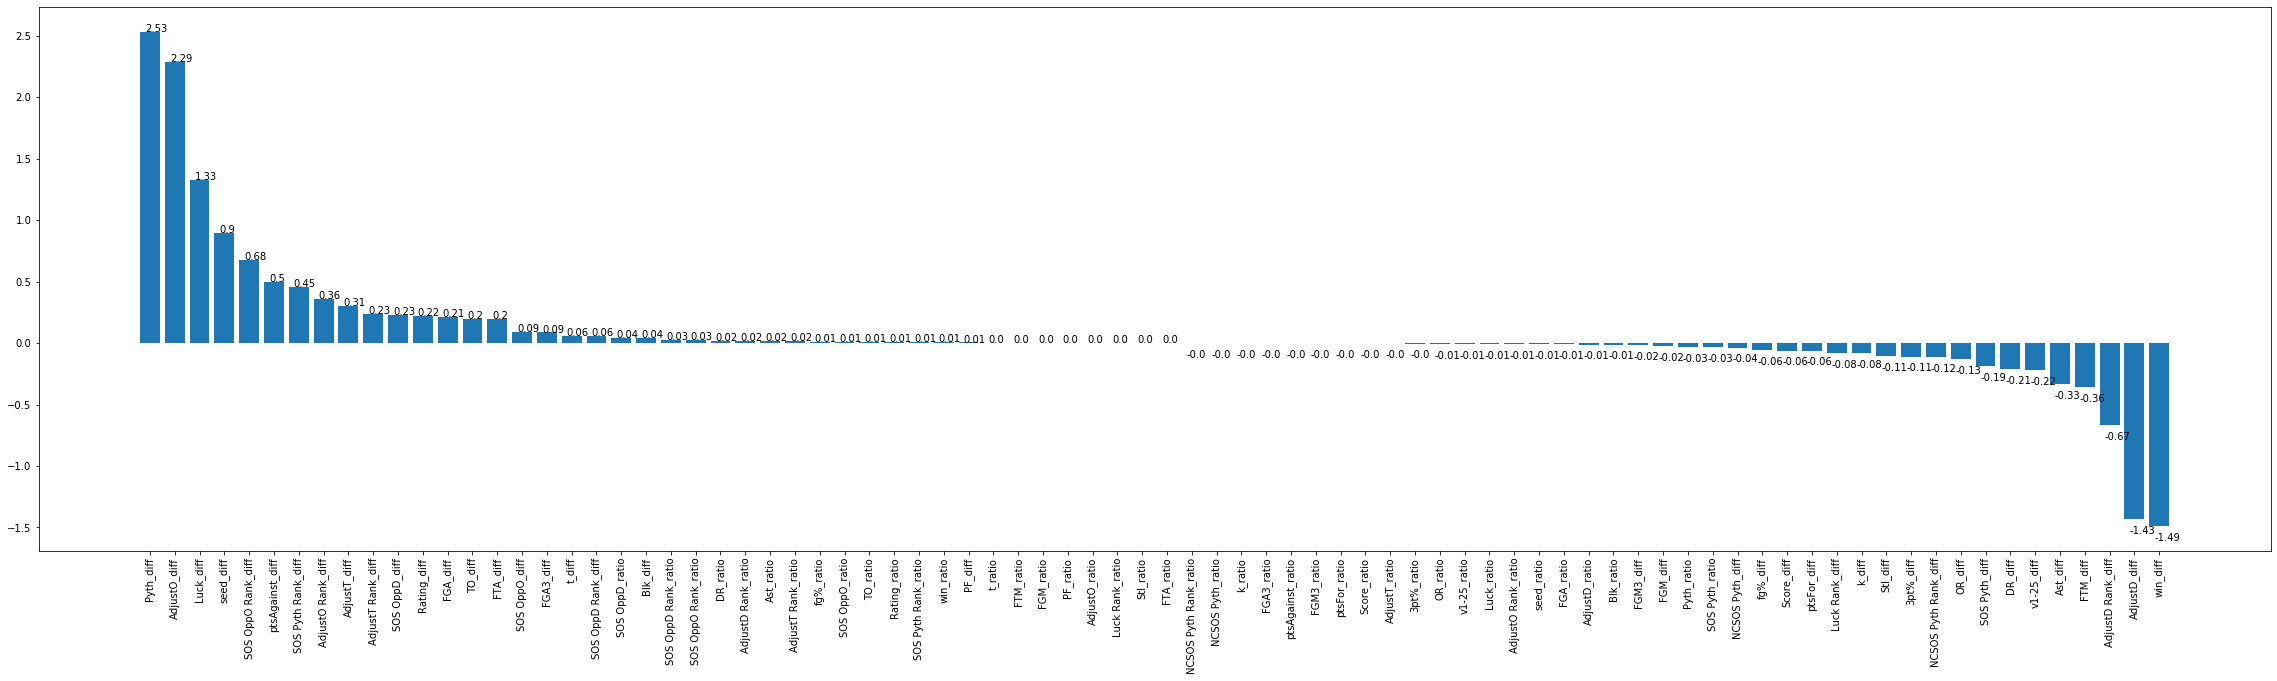

In [0]:
plt.figure(figsize=(40,10))
plt.bar(LR_coefs['Variable'],LR_coefs['Coef'])
plt.xticks(range(len(LR_coefs)), LR_coefs['Variable'], rotation=90);
for i, v in enumerate(LR_coefs['Coef']):
  if v > 0:
    plt.text(range(len(LR_coefs))[i] -.2, v, str(round(v,2)))
  if v < 0:
    plt.text(range(len(LR_coefs))[i] -.2, v-.12, str(round(v,2))) 

In [0]:
LR_keep = list(LR_coefs[(LR_coefs['Coef'] >.2) | (LR_coefs['Coef'] <-.2)]['Variable'])

In [0]:
LR_keep = LR_keep + ['Season', 'team_x', 'team_y','result']

In [0]:
train1 = train_set.copy()
train1 = train1[LR_keep]

In [0]:
#Logistic Regression
LR = LogisticRegression(C=1,max_iter = 1E6,penalty='l2')
seasons = [2015,2016,2017,2018,2019]
for s in seasons:
    train_test_window_fit(LR, train1, s, 2007)

2015 Log_loss 0.435 Acc: 0.806
2016 Log_loss 0.4073 Acc: 0.791
2017 Log_loss 0.3551 Acc: 0.8358
2018 Log_loss 0.3859 Acc: 0.791
2019 Log_loss 0.2829 Acc: 0.8955


In [0]:
#NN MLP Classifier
import warnings
warnings.filterwarnings("ignore")

mlp = MLPClassifier()
seasons = [2015,2016,2017,2018,2019]
for s in seasons:
    train_test_window_fit(mlp, train1, s, 2007)

2015 Log_loss 0.4274 Acc: 0.8209
2016 Log_loss 0.5073 Acc: 0.806
2017 Log_loss 0.3665 Acc: 0.791
2018 Log_loss 0.4507 Acc: 0.806
2019 Log_loss 0.3077 Acc: 0.8209
